In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [3]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [4]:
parts = df['entry'][0].split()
output = {}

output['ip'] = parts[0]
output['timestamp'] = parts[3][1:].replace(':', ' ', 1)

In [5]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [6]:

df = df.entry.apply(parse_log_entry)


In [20]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [11]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

/var/folders/ph/3fq5z80j5qjd537qn7g5pphc0000gn/T/ipykernel_11581/178743430.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [7]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [8]:
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})
ip_df.head()

,ip,count
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [10]:
# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df2.head()

,ip,proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


<AxesSubplot:>

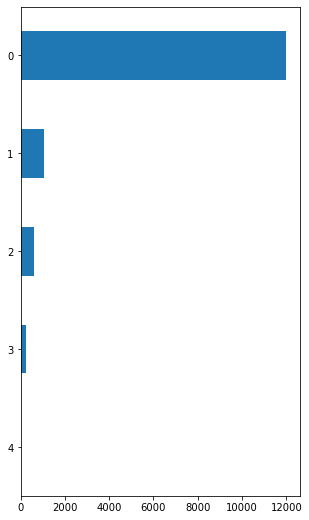

In [12]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [13]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index())
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [14]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,HTTP/1.1,1.000000
20,95.31.18.119,HTTP/1.1,1.000000
21,97.105.15.120,HTTP/1.1,1.000000
23,97.105.19.58,499,0.001167
24,97.105.19.58,HTTP/1.1,0.000083


In [15]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998750
23,97.105.19.58,499,0.001167
24,97.105.19.58,HTTP/1.1,0.000083


In [16]:
df.request_path.value_counts()

/api/v1/sales?page=2       709
/api/v1/items              464
/api/v1/items?page=2       291
/api/v1/items?page=3       219
/api/v1/stores             162
                          ... 
/api/v1/items?page=0         1
/api/v1/stores?page=999      1
/api/v1/stores?page=2        1
/api/v1/stores?page=666      1
/api/v1/helloclass!          1
Name: request_path, Length: 219, dtype: int64

In [17]:
df.request_path.value_counts(normalize=True)

/api/v1/sales?page=2       0.050723
/api/v1/items              0.033195
/api/v1/items?page=2       0.020818
/api/v1/items?page=3       0.015667
/api/v1/stores             0.011590
                             ...   
/api/v1/items?page=0       0.000072
/api/v1/stores?page=999    0.000072
/api/v1/stores?page=2      0.000072
/api/v1/stores?page=666    0.000072
/api/v1/helloclass!        0.000072
Name: request_path, Length: 219, dtype: float64

In [19]:
df.status_code.value_counts(normalize=True)

200         0.998569
499         0.001145
HTTP/1.1    0.000286
Name: status_code, dtype: float64

In [18]:
for col in df.columns:
    print(col.upper())
    print(df[col].value_counts())
    print('--------------------')

IP
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64
--------------------
REQUEST_METHOD
GET                     13974
21/Apr/2019 10:02:41        1
17/Apr/2019 19:36:41        1
18/Apr/2019 19:42:41        1
19/Apr/2019 19:42:41        1
Name: request_method, dtype: int64
--------------------
REQUEST_PATH
/api/v1/sales?page=2       709
/api/v1/items              464
/api/v1/items?page=2       291
/api/v1/items?page=3       219
/api/v1/stores             162
                          ... 
/api/

In [21]:
df.columns

Index(['ip', 'request_method', 'request_path', 'http_version', 'status_code',
       'size', 'user_agent', 'size_mb'],
      dtype='object')

In [22]:
status_given_agent = (
    df.groupby('user_agent')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_agent')
    .reset_index())
status_given_agent.head()

,user_agent,status_code,proba_status_given_agent
0,1005,HTTP/1.1,1.0
1,2560,HTTP/1.1,1.0
2,1153005,HTTP/1.1,1.0
3,2056327,HTTP/1.1,1.0
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,200,1.0


In [23]:
status_given_agent[status_given_agent.status_code != '200']

,user_agent,status_code,proba_status_given_agent
0,1005,HTTP/1.1,1.000000
1,2560,HTTP/1.1,1.000000
2,1153005,HTTP/1.1,1.000000
3,2056327,HTTP/1.1,1.000000
12,python-requests/2.20.1,499,0.002093
14,python-requests/2.21.0,499,0.001000


In [24]:
status_given_size = (
    df.groupby('size_mb')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_size')
    .reset_index())
status_given_size.head()

,size_mb,status_code,proba_status_given_size
0,0.0,499,1.0
1,0.00004,200,1.0
2,0.000046,200,1.0
3,0.00012,200,1.0
4,0.000154,200,1.0


In [25]:
status_given_size[status_given_size.status_code != '200']

,size_mb,status_code,proba_status_given_size
0,0.0,499,1.0
187,python-requests/2.21.0,HTTP/1.1,1.0
